In [1]:
import aesara
from aesara.graph.op import Op
from aesara.graph.basic import Apply
from aesara.tensor import as_tensor_variable
from aesara import tensor as tt
import numpy as np

In [60]:
def compute_quad(t, a, b, c):
    return a * t * t + b * t + c, t * t, t, np.zeros_like(t)

class QuadraticOp(Op):
    __props__ = ()
    
    def __init__(self, t):
        self.t = t

    def make_node(self, *args):
        inputs = list(map(as_tensor_variable, args))
        outputs = [
            tt.tensor(
                broadcastable=tuple(inputs[0].broadcastable) + (False,),
                dtype=inputs[0].dtype,
            )
            for _ in range(4)
        ]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, output_storage):        
        a, b, c = inputs
        
        f, dfda, dfdb, dfdc = compute_quad(t, a, b, c)
        output_storage[0][0] = f
        output_storage[1][0] = dfda
        output_storage[2][0] = dfdb
        output_storage[3][0] = dfdc

    #def infer_shape(self, fgraph, node, i0_shapes):
    #    return i0_shapes

    def grad(self, inputs, output_grads):
        
        f, dfda, dfdb, dfdc = self(*inputs)
        dcdf = output_grads[0]
        
        return [tt.dot(dcdf, dfda), tt.dot(dcdf, dfdb), tt.dot(dcdf, dfdc)]
        #return [output_grads[0] * 2]

    def R_op(self, inputs, eval_points):
        # R_op can receive None as eval_points.
        # That mean there is no diferientiable path through that input
        # If this imply that you cannot compute some outputs,
        # return None for those.
        if eval_points[0] is None:
            return eval_points
        return self.grad(inputs, eval_points)

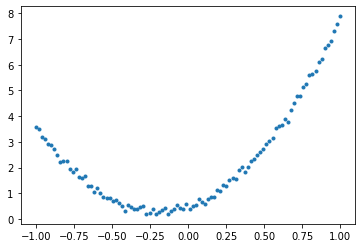

In [64]:
import matplotlib.pyplot as plt

t = np.linspace(-1, 1, 100)
atrue = 5.2
btrue = 2.1
ctrue = 0.5
quadmean = QuadraticOp(t)
y = quadmean(atrue, btrue, ctrue)[0].eval() + np.random.randn(len(t)) * 0.1
plt.plot(t, y, '.')

In [65]:
import pymc as pmc
from aesara import tensor as tt

with pmc.Model() as model:
    
    a = pmc.Normal("a", mu=atrue, sigma=1.0)
    b = pmc.Normal("b", mu=btrue, sigma=1.0)
    c = pmc.Normal("c", mu=ctrue, sigma=1.0)
    lsigma = pmc.Normal("lsigma", mu=0.1, sigma=1.0)
    mean = QuadraticOp(t)
    mu = mean(a, b, c)[0]
    obs = pmc.Normal("obs", mu=mu, sigma=tt.exp(lsigma), observed=y)
    trace = pmc.sample(3000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, c, lsigma]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 257 seconds.


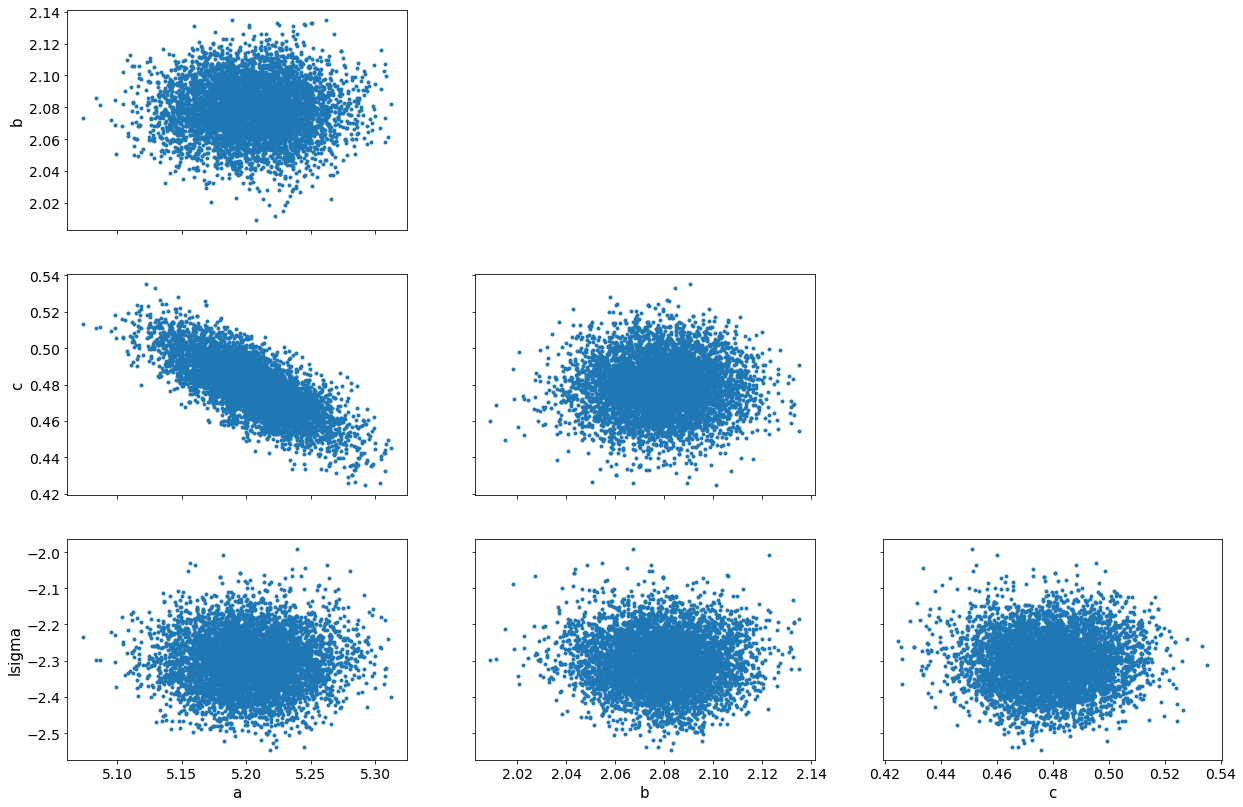

In [66]:
import arviz as az
az.plot_pair(trace, divergences=True);